All models to predict local values of total strain 


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import pandas as pd #Used to create dataframe
# import cupy as np #Used to calculate values in dataframe (plasticity for example)
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
# import scipy.stats
# import scipy.interpolate
# from sklearn.model_selection import train_test_split
# from ISLP import load_data , confusion_table
# from keras.models import Sequential
# from keras.layers import Dense
# import keras
import time
# from datetime import timedelta
# from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
# import matplotlib.colors as mcolors
import os #Used to get Data path
import tensorflow as tf
# from sklearn.svm import SVR 
# from sklearn.model_selection import GridSearchCV
from sklearn.tree import  DecisionTreeRegressor as DTR 
# from sklearn.metrics import accuracy_score ,log_loss
from sklearn.ensemble import RandomForestRegressor as RF
# from ISLP.bart import BART
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import ElasticNetCV
# from sklearn.linear_model import RidgeCV
# from sklearn.preprocessing import StandardScaler
# from matplotlib.pyplot import subplots
# from statsmodels.datasets import get_rdataset
# import sklearn.model_selection as skm
# from pygam import s as s_gam ,l as l_gam ,f as f_gam ,LinearGAM ,LogisticGAM
# from ISLP.transforms import BSpline ,NaturalSpline
# from ISLP.models import bs , ns
# from ISLP.pygam import approx_lam ,degrees_of_freedom ,plot as plot_gam ,anova as anova_gam
import statsmodels.api as sm
from ISLP.models import summarize ,poly ,ModelSpec as MS
# from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import PolynomialFeatures
# from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from keras.models import Sequential
from keras.layers import Dense
import keras
import random
random.seed(1)
np.random.seed(1)


In [ ]:
Data_sims_file = "C:\\Users\\Mehdi-GHRABLI\\Desktop\\New_Launch\\New_launch_files\\user_files" #Data_sims_file is the folder containing the simulation results


In [353]:
# Defining metrics : 
def metric_MSE(ground_truth,predictions):
    return mean_squared_error(ground_truth,predictions)
def metric_MAE(ground_truth,predictions):
    return mean_absolute_error(ground_truth,predictions)
def metric_R2(ground_truth,predictions):
    return r2_score(ground_truth,predictions)
def metric_adjusted_R2(ground_truth,predictions,n_obs,n_indep_variables):
    return 1-(1-r2_score(ground_truth,predictions))*(n_obs-1)/(n_obs-n_indep_variables-1)
def metric_MAPE(ground_truth,predictions):
    return np.mean(np.abs((ground_truth - predictions) / ground_truth))*100

In [354]:
pool_size = 500
pool = []
n_exp_per_iter = 10
init_exp = 50
Test_data_size = 50
# n_exp = 1000


Importing Data

In [ ]:
Design_point_folders = [ f.path for f in os.scandir(Data_sims_file) if f.is_dir() ]


In [356]:
Names_list = []
Current_list = []
Rh_list = []
Rw_list = []
Alpha_list = []
Temperature_list = []


Suff_contact= [" Contact Time 1.txt"," Contact Time 2.txt"]
Suff_metal= [" Metal Time 1.txt"," Metal Time 2.txt"]

Initial_local_names = [
    "Directional Deformation X",
    "Directional Deformation Y",
    "Directional Deformation Z",
    "Elastic Strain Intensity",
    "Equivalent Elastic Strain",
    "Equivalent Plastic Strain",
    "Equivalent Stress",
    "Equivalent Total Strain",
    "Maximum Principal Elastic Strain",
    "Maximum Principal Stress",
    "Maximum Shear Elastic Strain",
    "Maximum Shear Stress",
    "Middle Principal Elastic Strain",
    "Middle Principal Stress",
    "Minimum Principal Elastic Strain",
    "Minimum Principal Stress",
    "Normal Elastic Strain X",
    "Normal Elastic Strain Y",
    "Normal Elastic Strain Z",
    "Normal Stress X",
    "Normal Stress Y",
    "Normal Stress Z",
    "Shear Elastic Strain XY",
    "Shear Elastic Strain XZ",
    "Shear Elastic Strain YZ",
    "Shear Stress XY",
    "Shear Stress XZ",
    "Shear Stress YZ",
    "Stress Intensity",
    "Thermal Strain X",
    "Thermal Strain Y",
    "Thermal Strain Z",
    "Total Deformation"
]

Suff_ab_contact = ["_C1","_C2"]
Suff_ab_metal = ["_M1","_M2"]
Initial_local_names_ab = ["DDX","DDY","DDZ","ESI","EES","EPS","ES","ETS","MaxPES","MaxPS","MaxSES","MaxSS","MidPES","MidPS","MinPES","MinPS","NESX","MESY","NESZ","NSX","NSY","NSZ","SESXY","SESXZ","SESYZ","SSXY","SSXZ","SSYZ","SI","TSX","TSY","TSZ","TD"]

Final_local_names_contact = []
Final_local_names_metal = []

Final_local_ab_contact = []
Final_local_ab_metal = []



for i in Initial_local_names:
  for sC in Suff_contact:
    Final_local_names_contact.append(i+sC)
  for sM in Suff_metal:
    Final_local_names_metal.append(i+sM)

for i in Initial_local_names_ab:
  for sC in Suff_ab_contact:
    Final_local_ab_contact.append(i+sC)
  for sM in Suff_ab_metal:
    Final_local_ab_metal.append(i+sM)




In [357]:
#Contact
Contact_initial_train_data = pd.DataFrame()
#Add origin
for sf in tqdm(Design_point_folders[:init_exp]):
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  Contact_initial_train_data =pd.concat([Contact_initial_train_data,inst_df])
  

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


In [358]:
#Contact
Data_Pool= []
#Add origin
for sf in tqdm(Design_point_folders[init_exp:init_exp+pool_size]):
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  Data_Pool.append(inst_df)




100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


In [359]:
#Contact
Contact_test_data = pd.DataFrame()

#Add origin
for sf in tqdm(Design_point_folders[init_exp+pool_size:init_exp+pool_size+Test_data_size]):
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  Contact_test_data =pd.concat([Contact_test_data,inst_df])




100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Reducing data 

In [360]:
Input_names = ["Temperature (°C)","Contact major radius (mm)","X (mm)","Y (mm)","X2 (mm)","Y2 (mm)"]
Output_names = ["ETS_C1"]


Contact_initial_train_data = Contact_initial_train_data.loc[Contact_initial_train_data["Temperature (°C)"]>20]
Contact_initial_train_data["X2 (mm)"] = Contact_initial_train_data["X (mm)"]**2
Contact_initial_train_data["Y2 (mm)"] = Contact_initial_train_data["Y (mm)"]**2

Reduced_contact_initial_train_data = Contact_initial_train_data[Input_names+Output_names]
Reduced_contact_initial_train_data = Reduced_contact_initial_train_data.sample(frac=1).reset_index(drop=True)
# Reduced_contact_initial_train_data = (Reduced_contact_initial_train_data-Reduced_contact_initial_train_data.min())/(Reduced_contact_initial_train_data.max()-Reduced_contact_initial_train_data.min())

Contact_test_data = Contact_test_data.loc[Contact_test_data["Temperature (°C)"]>20]
Contact_test_data["X2 (mm)"] = Contact_test_data["X (mm)"]**2
Contact_test_data["Y2 (mm)"] = Contact_test_data["Y (mm)"]**2

Reduced_contact_test_data = Contact_test_data[Input_names+Output_names]
Reduced_contact_test_data = Reduced_contact_test_data.sample(frac=1).reset_index(drop=True)
# Reduced_contact_test_data = (Reduced_contact_test_data-Reduced_contact_test_data.min())/(Reduced_contact_test_data.max()-Reduced_contact_test_data.min())

reduced_pool =[]
for df_indx in range(len(Data_Pool)) :
    pool_df = Data_Pool[df_indx]
    pool_df = pool_df.loc[pool_df["Temperature (°C)"]>20]
    pool_df["X2 (mm)"] = pool_df["X (mm)"]**2
    pool_df["Y2 (mm)"] = pool_df["Y (mm)"]**2
    pool_df = pool_df[Input_names+Output_names+["Names"]]
    pool_df = pool_df.sample(frac=1).reset_index(drop=True)
    # pool_df = (pool_df-pool_df.min())/(pool_df.max()-pool_df.min())
    if len(pool_df)> 0 : 
        reduced_pool.append(pool_df)
    else : 
        print("Found empty")

Found empty
Found empty
Found empty
Found empty


In [361]:
#Normalizing data 
To_be_normalized = Input_names+Output_names
Max_arrays = []
Min_arrays = []
for element in To_be_normalized: 
    max_el = max(Reduced_contact_test_data[element].max(),Reduced_contact_initial_train_data[element].max())
    min_el = max(Reduced_contact_test_data[element].min(),Reduced_contact_initial_train_data[element].min())
    for df_indx in range(len(reduced_pool)) :
        pool_df = reduced_pool[df_indx]
        min_el = min(min_el,pool_df[element].min())
        max_el = max(max_el,pool_df[element].max())
    Max_arrays.append(max_el)
    Min_arrays.append(min_el)

for ind , element in enumerate(To_be_normalized): 
    Reduced_contact_initial_train_data[element] = (Reduced_contact_initial_train_data[element]-Min_arrays[ind])/(Max_arrays[ind]-Min_arrays[ind])
    Reduced_contact_test_data[element] = (Reduced_contact_test_data[element]-Min_arrays[ind])/(Max_arrays[ind]-Min_arrays[ind])
    for df_indx in range(len(reduced_pool)) :
        pool_df = reduced_pool[df_indx]
        pool_df[element] = (pool_df[element]-Min_arrays[ind])/(Max_arrays[ind]-Min_arrays[ind])

Initializing data 

In [362]:
X_train_active = Reduced_contact_initial_train_data[Input_names]
y_train_active = Reduced_contact_initial_train_data[Output_names]

X_test_active = Reduced_contact_test_data[Input_names]
y_test_active = Reduced_contact_test_data[Output_names]


X_train = Reduced_contact_initial_train_data[Input_names]
y_train = Reduced_contact_initial_train_data[Output_names]

X_test = Reduced_contact_test_data[Input_names]
y_test = Reduced_contact_test_data[Output_names]

In [363]:
n_iter = len(reduced_pool)//n_exp_per_iter
Stop_iter = n_iter//2
exp_pool_active = reduced_pool
exp_pool = reduced_pool

In [364]:
lrates=0.00001

In [365]:
KNN_model = KNeighborsRegressor(n_neighbors=15)
DecisionTree_model = DTR(max_depth =10)
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=True)
Bagging_model = RF(max_features=X_train.shape[1],n_estimators =500,random_state =0)

NNmodel = Sequential()

NNmodel.add(Dense(50, input_shape=(X_train.shape[1],),activation="relu"))
NNmodel.add(Dense(50, input_shape=(50,),activation="relu"))
NNmodel.add(Dense(1, input_shape=(50,),activation="relu"))

optimizer = keras.optimizers.Adam(learning_rate=lrates)
NNmodel.compile(loss='mse',optimizer=optimizer)




c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loop 

In [366]:
Ensemble_MSE_active = []
Ensemble_MAE_active = []
Ensemble_R2_active = []

for it in tqdm(range(n_iter)):
    # Knn model 
    KNN_model.fit(X_train_active, y_train_active)
    # Decision tree
    
    # DecisionTree_model.fit(X_train_active , y_train_active)
    #Polynomial model 
    X_Poly = poly.fit_transform(pd.DataFrame(X_train_active,columns=Input_names))
    Poly_model = sm.OLS(y_train_active, X_Poly)
    results_poly = Poly_model.fit()

    #Bagging model*
    Bagging_model.fit(X_train_active , y_train_active)

    #Neural Network
    history = NNmodel.fit(X_train_active, y_train_active, epochs=100,verbose=0)

    # Prediction for test KNN
    y_hat_knn = KNN_model.predict(X_test_active).ravel()
    # Prediction for test poly
    X_test_Poly = poly.fit_transform(X_test_active)
    new_predictions_test = results_poly.get_prediction(X_test_Poly)
    y_hat_poly_test = new_predictions_test.predicted_mean
    # # Prediction for test DT
    # y_hat_DT_test = DecisionTree_model.predict(X_test_active).ravel()

    # Prediction for test Bagging
    y_hat_bag_test = Bagging_model.predict(X_test_active).ravel()
    # Prediction for test Neural Network
    # y_hat_NN_test = NNmodel.predict(X_test_active,verbose=0).ravel()


    # y_hat_ensemble = np.mean([y_hat_NN_test,y_hat_poly_test,y_hat_knn,y_hat_bag_test],axis=0)
    y_hat_ensemble = np.mean([y_hat_poly_test,y_hat_knn,y_hat_bag_test],axis=0)

    Ensemble_MSE_active.append(metric_MSE(y_test_active,y_hat_ensemble))
    Ensemble_MAE_active.append(metric_MAE(y_test_active,y_hat_ensemble))
    Ensemble_R2_active.append(metric_R2(y_test_active,y_hat_ensemble))
    

    Exp_variance = []
    Exp_name=[]
    for exp_index in range(len(exp_pool_active)) : 

        Exp_name.append(exp_pool_active[exp_index]["Names"].iloc[0])
        Exp_input = exp_pool_active[exp_index][Input_names]
        Exp_output = exp_pool_active[exp_index][Output_names]
        #KNN predictions 
        y_hat_knn = KNN_model.predict(Exp_input).ravel()

        # Poly predictions 
        X_test_exp_Poly = poly.fit_transform(Exp_input)
        new_predictions_exp = results_poly.get_prediction(X_test_exp_Poly)
        y_hat_poly = new_predictions_exp.predicted_mean

        #Decision tree predicitions
        # y_hat_DT = DecisionTree_model.predict(Exp_input).ravel()

        #Bagging prediction
        y_hat_bag = Bagging_model.predict(Exp_input).ravel()

        #Neural network prediction
        # y_hat_NN = NNmodel.predict(Exp_input,verbose=0).ravel()
        

        # Var = np.mean(np.var([y_hat_knn,y_hat_poly,y_hat_bag,y_hat_NN],axis=0))
        Var = np.mean(np.var([y_hat_knn,y_hat_poly,y_hat_bag],axis=0))
        Exp_variance.append(Var)
    Order_exp = np.flip(np.argsort(Exp_variance))[:n_exp_per_iter]
    Left_exp = np.flip(np.argsort(Exp_variance))[n_exp_per_iter:]

    Added_X_train=pd.DataFrame()
    Added_Y_train=pd.DataFrame()
    for ind_dat in Order_exp:
        pool_X = exp_pool_active[ind_dat][Input_names]
        pool_Y = exp_pool_active[ind_dat][Output_names]
        Added_X_train = pd.concat([Added_X_train,pool_X])
        Added_Y_train = pd.concat([Added_Y_train,pool_Y])
    
    X_train_active = pd.concat([X_train_active,Added_X_train])
    y_train_active = pd.concat([y_train_active,Added_Y_train])

    exp_pool_active = [exp_pool_active[ind_left] for ind_left in Left_exp]



  0%|          | 0/49 [00:00<?, ?it/s]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
  2%|▏         | 1/49 [01:59<1:35:41, 119.60s/it]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
  4%|▍         | 2/49 [04:04<1:36:20, 122.98s/it]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using 

In [369]:
Ensemble_MSE = []
Ensemble_MAE = []
Ensemble_R2 = []

for it in tqdm(range(n_iter)):
    # Knn model 
    KNN_model.fit(X_train, y_train)

    # Decision tree
    # DecisionTree_model.fit(X_train , y_train)

    #Polynomial model 
    X_Poly = poly.fit_transform(pd.DataFrame(X_train,columns=Input_names))
    Poly_model = sm.OLS(y_train, X_Poly)
    results_poly = Poly_model.fit()

    #Bagging model
    Bagging_model.fit(X_train , y_train)
    #Neural network model
    # history = NNmodel.fit(X_train, y_train, epochs=100,verbose=0)

    # Prediction for test KNN
    y_hat_knn_test = KNN_model.predict(X_test).ravel()

    # Prediction for test poly
    X_test_Poly = poly.fit_transform(X_test)
    new_predictions_test = results_poly.get_prediction(X_test_Poly)
    y_hat_poly_test = new_predictions_test.predicted_mean

    # Prediction for test DT
    # y_hat_DT_test = DecisionTree_model.predict(X_test).ravel()

    # Prediction for test Bagging
    y_hat_bag_test = Bagging_model.predict(X_test).ravel()

    #Neural network prediction
    # y_hat_NN_test = NNmodel.predict(X_test).ravel()

    
    # y_hat_ensemble = np.mean([y_hat_bag_test,y_hat_poly_test,y_hat_knn_test,y_hat_NN_test],axis=0)
    y_hat_ensemble = np.mean([y_hat_bag_test,y_hat_poly_test,y_hat_knn_test],axis=0)
    Ensemble_MSE.append(metric_MSE(y_test,y_hat_ensemble))
    Ensemble_MAE.append(metric_MAE(y_test,y_hat_ensemble))
    Ensemble_R2.append(metric_R2(y_test,y_hat_ensemble))

    Added_X_train=pd.DataFrame()
    Added_Y_train=pd.DataFrame()

    for ind_dat in range(n_exp_per_iter):
        pool_X = exp_pool[ind_dat][Input_names]
        pool_Y = exp_pool[ind_dat][Output_names]
        Added_X_train = pd.concat([Added_X_train,pool_X])
        Added_Y_train = pd.concat([Added_Y_train,pool_Y])
    
    X_train = pd.concat([X_train,Added_X_train])
    y_train = pd.concat([y_train,Added_Y_train])

    exp_pool = exp_pool[n_exp_per_iter:]






  0%|          | 0/49 [00:00<?, ?it/s]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
  2%|▏         | 1/49 [00:49<39:24, 49.27s/it]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
  4%|▍         | 2/49 [01:47<42:52, 54.73s/it]c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\tf_env_test\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

Text(0, 0.5, 'MSE')

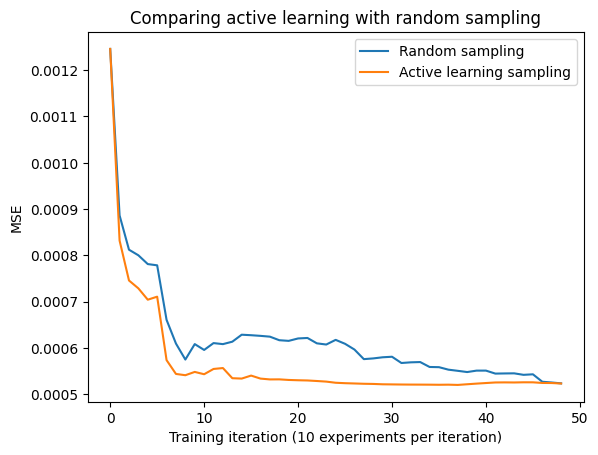

In [370]:

plt.plot(Ensemble_MSE,label="Random sampling")
plt.plot(Ensemble_MSE_active,label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

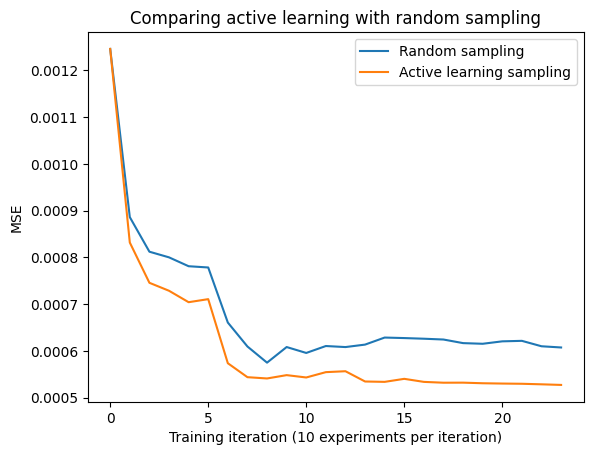

In [371]:

plt.plot(Ensemble_MSE[:Stop_iter],label="Random sampling")
plt.plot(Ensemble_MSE_active[:Stop_iter],label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("MSE")

Text(0, 0.5, 'MAE')

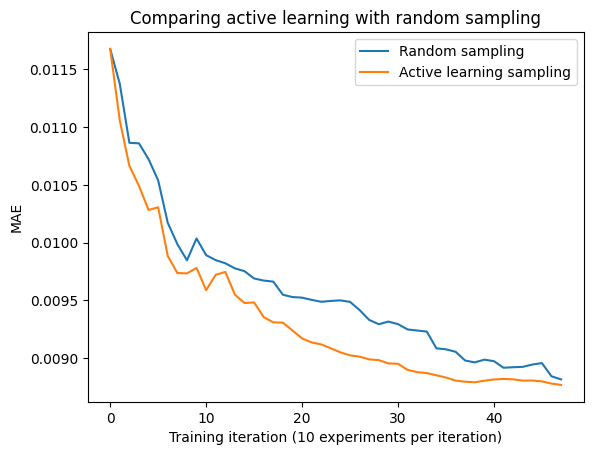

In [372]:

plt.plot(Ensemble_MAE[:-1],label="Random sampling")
plt.plot(Ensemble_MAE_active[:-1],label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("MAE")

Text(0, 0.5, 'MAE')

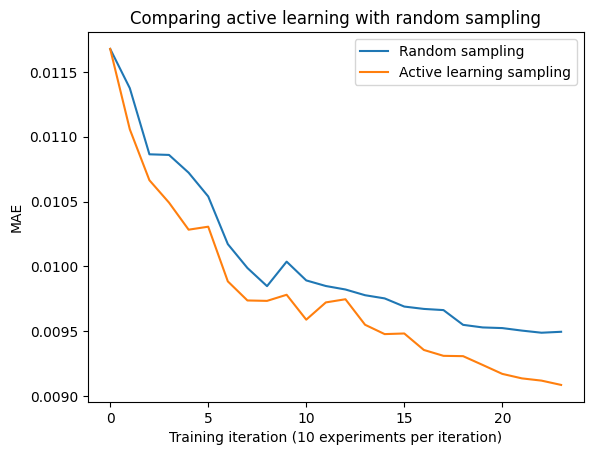

In [373]:

plt.plot(Ensemble_MAE[:Stop_iter],label="Random sampling")
plt.plot(Ensemble_MAE_active[:Stop_iter],label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("MAE")

Text(0, 0.5, 'R2')

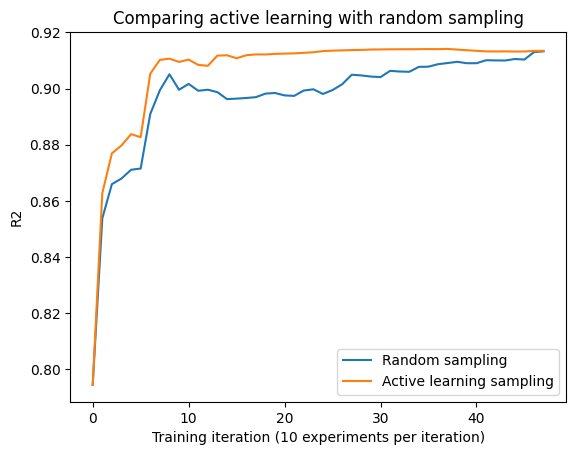

In [374]:

plt.plot(Ensemble_R2[:-1],label="Random sampling")
plt.plot(Ensemble_R2_active[:-1],label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("R2")

Text(0, 0.5, 'R2')

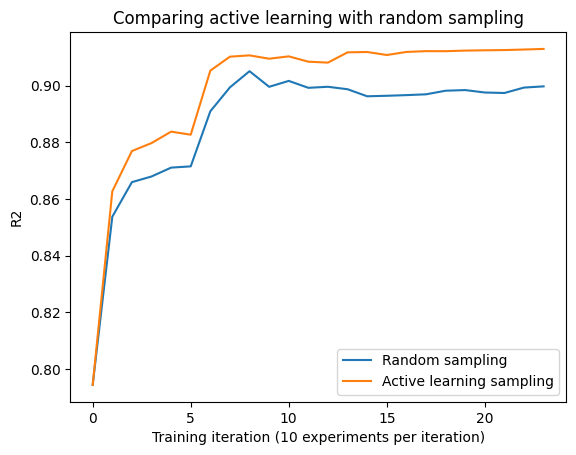

In [375]:

plt.plot(Ensemble_R2[:Stop_iter],label="Random sampling")
plt.plot(Ensemble_R2_active[:Stop_iter],label="Active learning sampling")
plt.title("Comparing active learning with random sampling")
plt.legend()
plt.xlabel("Training iteration ("+ str(n_exp_per_iter)+" experiments per iteration)")
plt.ylabel("R2")